In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import seaborn as sns
import collections

import warnings
warnings.filterwarnings('ignore')

# Utils
file_path = os.getcwd()
utils_path = os.path.abspath(os.path.join(file_path, '../src/data'))
sys.path.append(utils_path)
import utils_data

In [2]:
# Load agg response
# rsp = pd.read_csv(os.join.path(file_path, '../data/from_combined'))
rsp = pd.read_csv('/Users/apartin/work/jdacs/Benchmarks/Data/Pilot1/combined_single_response_agg', sep='\t')
rsp.insert(loc=2, column='CELL_abs', value=rsp['CELL'].map(lambda s: s.split('.')[1]))
print('rsp.shape', rsp.shape)
display(rsp[:2])

(4484081, 15)


,SOURCE,CELL,CELL_abs,DRUG,STUDY,AUC,IC50,EC50,EC50se,R2fit,Einf,HS,AAC1,AUC1,DSS1
0,CCLE,CCLE.1321N1,1321N1,CCLE.1,fake_exp,0.8330,4.883,5.183,0.5746,0.9864,0.2017,0.7463,0.1017,0.8983,0.0551
1,CCLE,CCLE.1321N1,1321N1,CCLE.10,fake_exp,0.7909,5.217,5.217,2.2840,0.6526,0.0000,0.8993,0.1136,0.8864,0.0728


# Top6

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
from pathlib import Path
import pandas as pd
import numpy as np

In [2]:
df = pd.read_parquet('../uniq.top6.reg.parquet', engine='auto', columns=None)
col_idx = df.nunique(dropna=True).values==1  # col indexes to drop
df = df.iloc[:, ~col_idx]

print(df.shape)

(283152, 3765)


In [3]:
def split_cell_drug(dff):
    """ Split drug and cell features. """
    dff = dff.copy()
    dd_cols = [c for c in df.columns if 'DD_' in c]
    ge_cols = [c for c in df.columns if 'GE_' in c]
    dd = dff[dd_cols]
    ge = dff[ge_cols]
    print('\ndd.shape', dd.shape)
    print('ge.shape', ge.shape)
    return dd, ge


def add_lbl_dup(dff, label_name='lb', prffx='_'):
    """ Add col indicating with unique row (label). """
    idx_org = dff.index.values
    
    # Sort rows (duplicated rows will be concateneted)
    dff = dff.sort_values(by=dff.columns.tolist())
    # Add boolean col indicating the start of new unique row
    dff = pd.concat([dff.duplicated(keep='first'), dff], axis=1).rename(columns={0: 'd'})

    # Add col indicating a unique row
    c = -1
    v = np.ones((len(dff),))
    for i, x in enumerate(dff['d']):
        # if i % 50000 == 0: print(i)
        if x is False:
            c += 1
            v[i] = int(c)
        else:
            v[i] = c

    dff.insert(loc=1, column=label_name, value=v) 
    dff = dff.reindex(idx_org)
    dff = dff.drop(columns=['d'])
    
    dff[label_name] = dff[label_name].map(lambda x: prffx + str(int(x)))
    return dff

In [4]:
dd, ge = split_cell_drug(dff=df)
dlb = add_lbl_dup(dd, label_name='dlb', prffx='d')['dlb']
clb = add_lbl_dup(ge, label_name='clb', prffx='c')['clb']


dd.shape (283152, 2822)
ge.shape (283152, 942)


In [6]:
dd[:2]

,DD_MW,DD_AMW,DD_Sv,DD_Se,DD_Sp,DD_Si,DD_Mv,DD_Me,DD_Mp,DD_Mi,...,DD_Psychotic-80,DD_Psychotic-50,DD_Hypertens-80,DD_Hypertens-50,DD_Hypnotic-80,DD_Hypnotic-50,DD_Neoplastic-80,DD_Neoplastic-50,DD_Infective-80,DD_Infective-50
0,974.73,8.123,76.158,121.421,80.927,135.681,0.635,1.012,0.674,1.131,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,974.73,8.123,76.158,121.421,80.927,135.681,0.635,1.012,0.674,1.131,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
ge[:2]

,GE_AARS,GE_ABCB6,GE_ABCC5,GE_ABCF1,GE_ABCF3,GE_ABHD4,GE_ABHD6,GE_ABL1,GE_ACAA1,GE_ACAT2,...,GE_ZMIZ1,GE_ZMYM2,GE_ZNF131,GE_ZNF274,GE_ZNF318,GE_ZNF395,GE_ZNF451,GE_ZNF586,GE_ZNF589,GE_ZW10
0,-2.7680,-0.929,-0.7397,-2.2230,-2.08,-0.624,-0.010086,0.3992,0.6140,-0.65500,...,0.1420,-0.7695,-0.4844,-0.6543,-1.4460,-0.8420,-0.3555,-0.4753,-1.339,-0.4937
1,0.8354,0.553,-0.3386,0.6025,-0.73,-0.685,1.184000,0.4116,-0.0731,-0.01535,...,0.5327,0.6830,0.0725,0.2411,-0.2615,-0.1866,-0.2996,1.3545,1.356,1.5620


In [8]:
print(len(dlb.unique()))
print(len(clb.unique()))

1748
748


## How come there combinations that were tested more than 100 times??

In [15]:
# Unique combinations
xdata = df.iloc[:,1:].copy()
df_ = add_lbl_dup(xdata, label_name='cmb', prffx='s')

In [21]:
# How come there combinations that were tested more than 100 times??
df_['cmb'].value_counts()[:5]

s2551    128
s2553    127
s2552    127
s2542    126
s2558    125
Name: cmb, dtype: int64

In [22]:
print(x_tmp.shape)
x_tmp = xdata.drop_duplicates()
print(x_tmp.shape)

In [ ]:
mm = dlb + '_' + clb
mm.value_counts()[:10]

## Plot wrm and ref curves

In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
from glob import glob
path = Path(os.getcwd())

import matplotlib.pyplot as plt

In [2]:
path = path/'../models/candle_accl_trn'
# split_by = 'cell'
split_by = 'none'

wrmdir = path/'wrm'/f'split_by_{split_by}'
refdir = path/'ref'/f'split_by_{split_by}'

In [3]:
h_wrm = pd.read_csv(wrmdir/'keras_history.csv')
h_ref = pd.read_csv(refdir/'keras_history.csv')

In [4]:
h_wrm['epoch'] = h_wrm.index.values + 1
h_ref['epoch'] = h_wrm.index.values + 1
skip_epochs = 10

In [5]:
OUTDIR = path

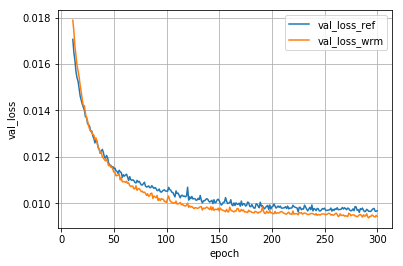

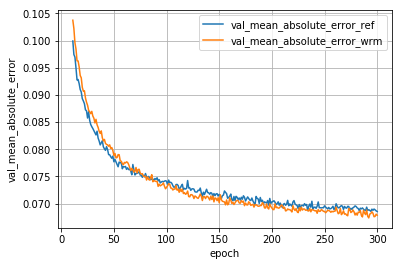

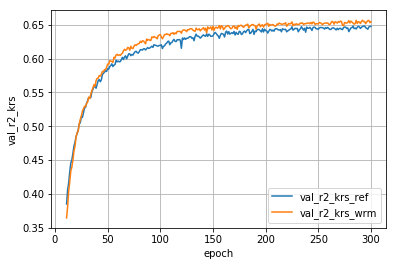

In [6]:
# Plot WRM vd REF curves
h_wrm = pd.read_csv(wrmdir/'keras_history.csv')
h_ref = pd.read_csv(refdir/'keras_history.csv')
val_cols_names = [c for c in h_ref.columns if 'val_' in c]
for c in val_cols_names:
    fig, ax = plt.subplots()
    ax.plot(h_ref['epoch'][skip_epochs:], h_ref[c][skip_epochs:], label=c+'_ref')
    ax.plot(h_wrm['epoch'][skip_epochs:], h_wrm[c][skip_epochs:], label=c+'_wrm')
    ax.set_xlabel('epoch')
    ax.set_ylabel(c)
    plt.legend(loc='best')
    plt.grid(True)
    # plt.savefig(outdir/f'ref_vs_wrm_{c}.png', bbox_inches='tight')

In [7]:
h_ref['val_loss'].values[-1]

0.009674411364821294

In [8]:
ref_ep = 300
# weps = 40
weps = 280

In [9]:
cdir = path / f'cnt_val_loss_at_{ref_ep}' / f'split_by_{split_by}' / f'weps_{weps}'
kh = pd.read_csv(cdir/'model.cnt.log')
kh['epoch'] += 1

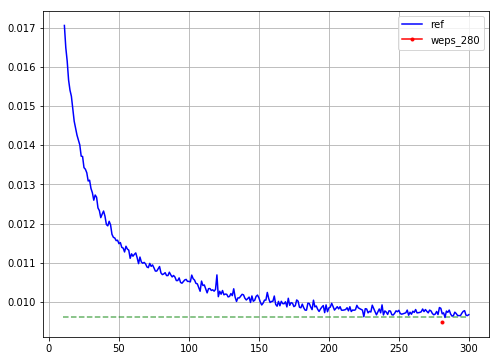

In [13]:
skp_ep = 10
# c = 'val_r2_krs'
c = 'val_loss'

fig, ax = plt.subplots(figsize=(8, 6))

x1 = list(h_ref['epoch'][skp_ep:])
x2 = list(kh['epoch'] + weps)

x = np.array(range(skp_ep, max(x1+x2)))
y = np.ones(len(x)) * min(h_ref[c])        
ax.plot(x, y, 'g--', alpha=0.6)  

ax.plot(x1, h_ref[c][skp_ep:], 'b-', label='ref')
ax.plot(x2, kh[c], 'ro-', markersize=3, label=f'weps_{weps}')

plt.legend()
plt.grid(True)

## Plot ref vs cnt

In [11]:
val_cols_names = [c for c in h_ref.columns if 'val_' in c]

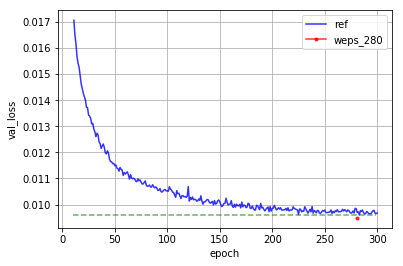

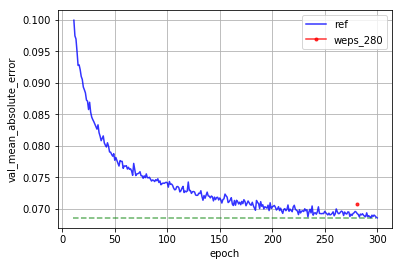

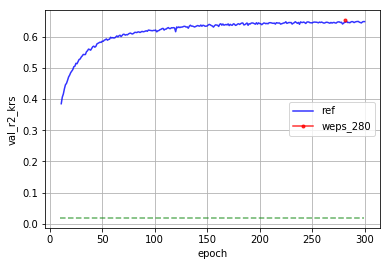

In [14]:
for c in val_cols_names:
    fig, ax = plt.subplots()

    x1 = list(h_ref['epoch'][skp_ep:])
    x2 = list(kh['epoch'] + weps)    
    
    x = np.array(range(skp_ep, max(x1+x2)))
    y = np.ones(len(x)) * min(h_ref[c])        
    ax.plot(x, y, 'g--', alpha=0.6)      

    ax.plot(x1, h_ref[c][skp_ep:], 'b-', alpha=0.8, label='ref')
    ax.plot(x2, kh[c], 'ro-', markersize=3, alpha=0.8, label=f'weps_{weps}')      
        
    ax.set_xlabel('epoch')
    ax.set_ylabel(c)
    plt.legend(loc='best')
    plt.grid(True)
    # plt.savefig(outdir/f'wrm_vs_ref_{c}.png', bbox_inches='tight')

## Comprae weps vs ceps plots of none, cell, both

No handles with labels found to put in legend.


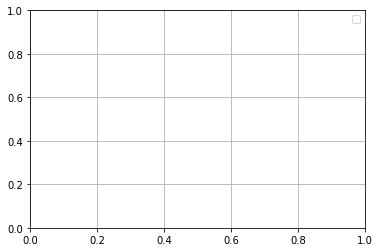

In [17]:
dirs = glob(str(path/'../models/candle_accl_trn'/f'cnt_val_loss_at_{ref_ep}/*'))
fig, ax = plt.subplots()
for d in dirs:
    print(d)
    lb = d.split('_')[-1]
    print(lb)
    if lb == 'cell':
        continue
    df = pd.read_csv(Path(d)/'summary.csv')
    ax.plot(df['weps'], df['ceps'], '-o', markersize=3, label=lb)
    
plt.grid(True)
plt.legend(loc='best');
    

In [ ]:
cdir = path / f'cnt_val_loss_at_{ref_ep}' / f'split_by_{split_by}' / f'weps_{weps}'

In [79]:
glob(str(path/f'cnt_val_loss_at_{ref_ep}'))

[]

In [80]:
str(path/f'cnt_val_loss_at_{ref_ep}')

'/vol/ml/apartin/projects/cell-line-drug-sensitivity/notebooks/cnt_val_loss_at_300'